In [2]:
import datetime
import time

import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pgpasslib

import numpy as np

from query_precip import *
from query_temp import *
from query_rates import *
from query_helpers import *

%load_ext autoreload
%autoreload 2

In [3]:
connection_string = "postgresql+psycopg2://nannau@dbmsc.pcic.uvic.ca/msc"
engine = create_engine(connection_string)
Session = sessionmaker(bind=engine)
session = Session()

In [4]:
df_q = pd.read_sql(query_variables(session).statement, engine)
df_q.where(df_q['standard_name'].str.contains('temp')).dropna().head()

,vars_id,standard_name,long_description,unit,cell_method,net_var_name
5,1294.0,dew_point_temperature,Dew point temperature,0.1 Celsius,time: point,74
9,1299.0,air_temperature,AKA Dry Bulb Temperature,0.1 Celsius,,78
10,1300.0,wet_bulb_temperature,Wet bulb temperature,0.1 Celsius,,79
103,1392.0,air_temperature,Daily max temperature,0.1 Celsius,time: maximum,1
104,1393.0,air_temperature,Daily min temperature,0.1 Celsius,time: minimum,2


In [7]:
start_time = datetime.datetime(1982, 1, 1)
end_time = datetime.datetime(2000, 1, 31)
#days_in_month(start_time, end_time)
#df_15_min = pd.read_sql(query_rain_rate_15(start_time, end_time, session).statement, engine)
#df_all = pd.read_sql(rrall(start_time, end_time, session).statement, engine)

In [8]:
conn = engine.connect()

#df = pd.read_sql(temp_quantile(session, start_time, end_time, quantile=0.025).statement, engine)
#sql = full_cvg(session, start_time, end_time, net_var_name='2', cell_method='time: minimum', standard_name='air_temperature')
#df_has_rain = df_has_rain[df_has_rain['datum']<1.0]
#df_15_min = df_15_min[df_15_min['rainfall_rate']<1.0]
#conn.execute(full_cvg)
#dir(full_cvg)
#sql = temp_quantile(engine, start_time, end_time)
sql = pd.read_sql(temp_quantile(engine, start_time, end_time).statement, engine)
#for row in sql:
#    print(row)
#pd.read_sql(sql.statement, engine)
#conn.execute(full_cvg)
#pd.read_sql(full_cvg.execute.fetchall(), engine)
#df_has_rain
#pd.to_csv(df_has_rain, "df_rain_rate.csv")#[df_has_rain['rate'] != df_has_rain['total_rain']]

In [9]:
dir(sql)
sql

#for row in sql:
#    print(row)
#pd.read_sql(sql.fetchall(), engine)

,quantile,station_id,lat,lon
0,-5.00,18,48.9350,-123.7420
1,0.00,25,48.5167,-123.3670
2,-30.00,29,48.8244,-124.1330
3,0.00,32,48.8294,-124.0520
4,-43.84,38,48.7667,-123.6830
5,-28.94,39,48.7347,-123.7280
6,-15.00,48,48.8717,-123.4980
7,0.00,50,48.9850,-123.5730
8,-13.64,62,48.8447,-123.3200
9,-20.00,74,48.7639,-123.2870


In [33]:
#df = df_n
df.shape

(951, 4)

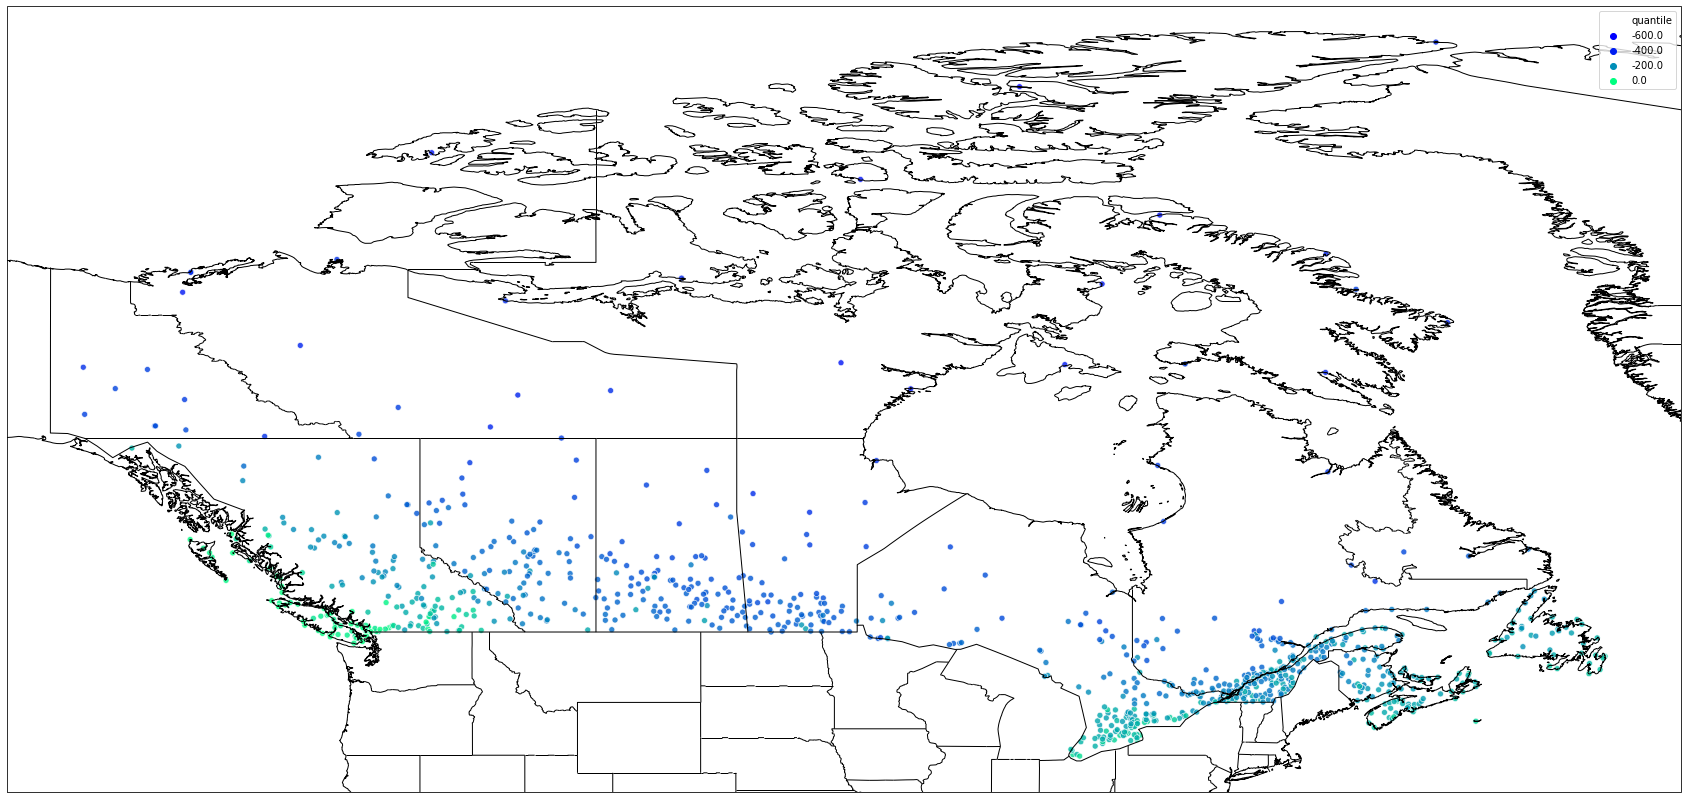

In [32]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(df['lon'], df['lat'], hue=df['quantile'], palette="winter", alpha=.8)
#plt.ylim(40, 80)
#plt.xlim(-126, -119)
plt.savefig('./plots/jan1/jan_1st_lower_temp.pdf')

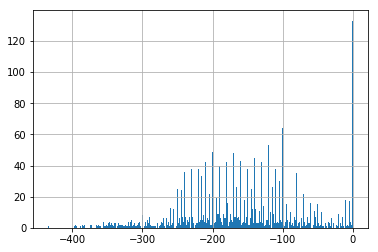

In [30]:
df['quantile'].hist(bins=400)

In [63]:
ndf = df[df['completeness']>=1.0].groupby('station_id').count()#.unique().shape, df['station_id'].shape
ndf[ndf['air_temperature'] >= 8]

#def mean(x):
#    return x.min()
#dff = df[df.completeness>=1.0]
#dff.join((dff.groupby('station_id').filter(lambda x: x['completeness'].count() >= 8.)['air_temperature']
#             .apply(mean)),
#        on='station_id', rsuffix='_min')#.filter(lambda x: x['completeness'].count() >= 8.)
#  .filter(lambda x: x['completeness'] >= 1.00))

KeyError: 'completeness'

In [62]:
df_complete = df[df['completeness'] > 0.8]
df_complete['air_temperature'].hist()#.shape[0] - df_complete.shape[0], df_complete.shape[0]

KeyError: 'completeness'

Text(0, 0.5, 'Number of Stations')

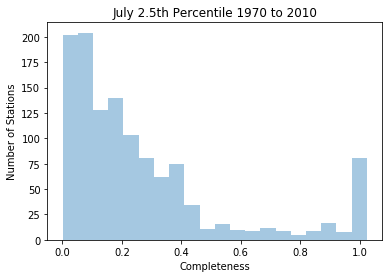

In [45]:
sns.distplot(df['completeness'].values, kde=False)
plt.title('July 2.5th Percentile {} to {}'.format(start_time.year, end_time.year))
plt.xlabel('Completeness')
plt.ylabel('Number of Stations')
#plt.savefig('./plots/jan1/july25_wet_percentilecompleteness')

Text(0, 0.5, 'Number of Stations')

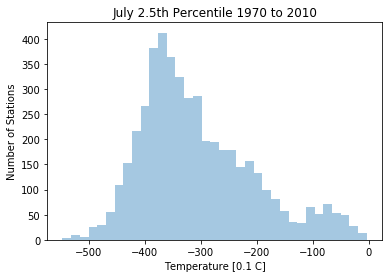

In [41]:
sns.distplot(df['air_temperature'].values, kde=False)
plt.title('July 2.5th Percentile {} to {}'.format(start_time.year, end_time.year))
plt.xlabel('Temperature [0.1 C]')
plt.ylabel('Number of Stations')
#plt.savefig('./plots/jan1/july25_wet_percentile_air_temp')

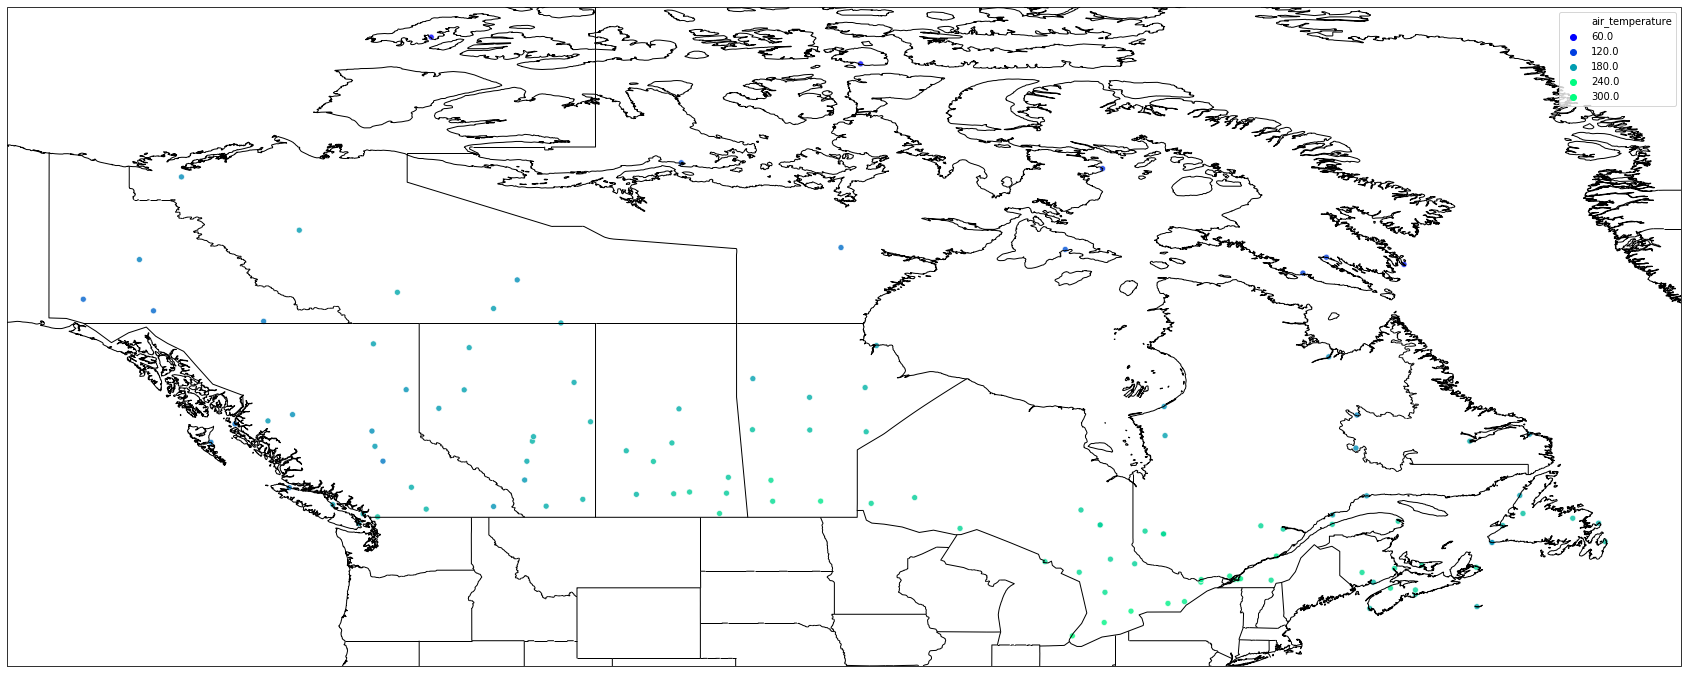

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(df_complete['lon'], df_complete['lat'], hue=df_complete['air_temperature'], palette="winter", alpha=.8)
#plt.ylim(40, 80)
#plt.xlim(-126, -119)
plt.savefig('./plots/jan1/july25_wet_percentile_spatial.pdf')

In [12]:
df_has_rain.to_csv("rain_rate.csv")

In [20]:
df_has_rain[~df_has_rain['native_id'].str.isnumeric()]

,rainfall_rate,min_time,max_time,lat,lon,station_id,native_id,completeness
0,188.0,1980-04-01,1980-10-31,41.9500,-82.5167,6140,613FN58,0.578050
38,32.0,1980-10-07,1980-10-31,43.7000,-79.4833,6549,61583FL,0.065440
43,147.0,1980-04-01,1980-10-31,43.7500,-79.3833,6657,615HHDF,0.520791
47,231.0,1980-04-01,1980-10-31,43.7833,-79.3500,6618,61587PG,0.498978
106,127.0,1980-01-09,1980-12-31,45.3167,-75.0833,11326,6101BF3,0.894342
135,141.0,1980-04-16,1980-10-26,45.5833,-73.8167,7126,702BL09,0.438991
170,102.0,1980-01-24,1980-12-31,46.2833,-65.7167,12302,81049LP,0.921609
176,92.0,1980-04-01,1980-10-26,46.3833,-72.6167,6843,701HE63,0.534424
197,0.0,1980-04-05,1980-11-03,46.7500,-71.2833,6823,7017B65,0.272665
198,0.0,1980-04-01,1980-11-06,46.7833,-71.3167,6824,7017BFN,0.313565


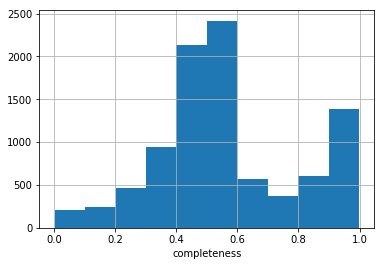

In [7]:
df_has_rain['completeness'].hist()
plt.xlabel('completeness')
plt.savefig('plots/completeness.png')

In [ ]:
df_has_rain[df_has_rain['completeness']<0.6]

In [ ]:
df_has_rain = df_has_rain[df_has_rain['datum']<1.0]
df_all = df_all[df_all['datum']<1.0]
df_all.head()
df_all.merge(df_has_rain, on='obs_time')[df_all.columns]

In [26]:
df_has_rain[df_has_rain['datum']<1.0]

,datum,obs_time,lat,lon,station_id
0,0.0,1986-01-01,48.5833,-123.4170,15
2,0.0,1986-01-03,48.5833,-123.4170,15
5,0.0,1986-01-06,48.5833,-123.4170,15
11,0.0,1986-01-12,48.5833,-123.4170,15
18,0.0,1986-01-19,48.5833,-123.4170,15
22,0.0,1986-01-23,48.5833,-123.4170,15
23,0.0,1986-01-24,48.5833,-123.4170,15
24,0.0,1986-01-25,48.5833,-123.4170,15
35,0.0,1986-02-05,48.5833,-123.4170,15
36,0.0,1986-02-06,48.5833,-123.4170,15


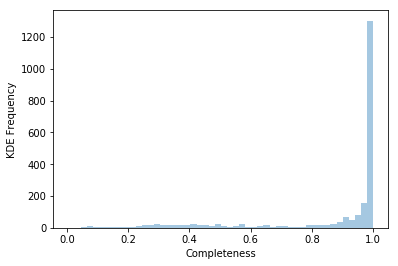

In [6]:
sns.distplot(df['anon_1'].values, kde=False)
plt.xlabel("Completeness")
plt.ylabel("KDE Frequency")
plt.savefig("plots/completeness_rainfall_rate.pdf")

In [14]:
annual_tot_precip = msc.query_annual_precip(session)
annual_tot_rain = msc.query_annual_rain(session)
query_temp = msc.query_design_temp_percentile(session)

In [15]:
query = msc.query_design_temp_percentile(session)

In [16]:
annual_tot_precip = msc.query_annual_precip(session)
#pd.read_sql(annual_tot_precip.statement, engine).head()

In [17]:
annual_tot_rain = msc.query_annual_rain(session)
#pd.read_sql(annual_tot_rain.statement, engine).head()

In [18]:
query_temp = msc.query_design_temp_percentile(session)
#pd.read_sql(query_temp.statement, engine)

In [19]:
query_design_temp_dry = msc.query_design_temp_dry(session)
#pd.read_sql(query_design_temp_dry.statement, engine).head()

In [20]:
query_design_temp_wet = msc.query_design_temp_wet(session)
#pd.read_sql(query_design_temp_wet.statement, engine)

In [21]:
hdd = msc.query_deg_day_below_18(session)
#pd.read_sql(hdd.statement, engine)

In [22]:
df_vars = pd.read_sql(msc.query_variables(session).statement, engine)
#df_vars[df_vars['net_var_name']=='127']
#df_vars[(df_vars['net_var_name'].astype(int) > 124) & (df_vars['net_var_name'].astype(int) < 132)]
df_test = df_vars[df_vars['standard_name'].str.contains('precip')]
df_test

,vars_id,standard_name,long_description,unit,cell_method,net_var_name
72,1361,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 00-60),0.1 mm,time: sum,262
73,1362,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 00-15),0.1 mm,time: sum,263
74,1363,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 15-30),0.1 mm,time: sum,264
75,1364,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 30-45),0.1 mm,time: sum,265
76,1365,lwe_thickness_of_precipitation_amount,precipitation amount (minutes 45-60),0.1 mm,time: sum,266
108,1397,lwe_thickness_of_precipitation_amount,Total precipitation,0.1 mm,time: sum,12
119,1412,lwe_thickness_of_precipitation_amount,1200 UTC,0.1 mm,time: sum,6
120,1413,lwe_thickness_of_precipitation_amount,1800 UTC,0.1 mm,time: sum,7
121,1414,lwe_thickness_of_precipitation_amount,0000 UTC,0.1 mm,time: sum,8
122,1415,lwe_thickness_of_precipitation_amount,0600 UTC,0.1 mm,time: sum,9


In [23]:
one_day_query = msc.query_rain_rate_15(session) 
#msc.query_rain_rate_one_day_1_50(session)
df_one_day = pd.read_sql(one_day_query.statement, engine)

In [25]:
df_one_day

,rainfall_rate,time_min,time_max,lat,lon,station_id,completeness,freq
0,5.4,2004-05-28 15:00:00,2004-12-31 23:00:00,45.6084,-61.6797,8313,0.595021,
1,8.2,2004-05-27 20:00:00,2004-12-31 23:00:00,46.4600,-61.9883,8368,0.597160,
2,235.6,2004-09-03 22:00:00,2004-12-31 23:00:00,48.3694,-89.3272,5302,0.325573,
3,1.5,2004-11-14 07:00:00,2004-12-31 23:00:00,49.3998,-98.3192,4674,0.130075,
4,503.6,2004-06-16 22:00:00,2004-12-31 23:00:00,50.4333,-104.6670,3990,0.498170,
5,306.8,2004-07-27 16:00:00,2004-12-31 23:00:00,50.6306,-93.2214,5112,0.425875,
6,306.5,2004-09-13 13:00:00,2004-12-31 23:00:00,55.5333,-102.3500,4417,0.294915,
7,428.9,2004-06-30 17:00:00,2004-12-31 23:00:00,64.3167,-96.0000,2092,0.473844,
8,0.0,2004-12-20 16:00:00,2004-12-31 23:00:00,70.4833,-68.5167,2208,0.023272,
9,241.7,2004-09-18 15:00:00,2004-09-21 16:00:00,72.6933,-77.9575,2283,0.008271,


In [ ]:
from gumbel import Gumbel
gum = Gumbel(10, 10)
gum.fit_transform(df=df_has_rain).dropna()

In [2]:
iv = 0.1

from scipy import interpolate
import lmoments3 as lm
from lmoments3 import distr
from scipy.stats import gumbel_r
#paras = distr.gam.lmom_fit(x)

def fit_gumbel(x):
    #x = x['rainfall_rate'].values
    N = x.shape[0]
    euler = 0.5772156649
    if N >= 10:
        paras = distr.gum.lmom_fit(x)
        #fitted_gum = distr.gum(**paras)
        #exval = fitted_gum.ppf(0.1)
        K_T = -(np.sqrt(6.)/np.pi)*(euler+np.log(np.log(10/9.))) 
        S = np.std(x)
        Y_bar = np.mean(x)+K_T*S
        
        lmoments = distr.gum.lmom(nmom=2, **paras)
        #lmoments = lm.lmom(x, nmom=2)
        alpha = lmoments[1]/np.log(2)
        xi = lmoments[0] - euler*alpha 
        ok = get_gumbel_design_value(xi, alpha)
        
        fitted_gum = distr.gum(**paras)
        #val = fitted_gum.ppf(0.9)
        return ok
    else:
        return np.nan
    
def get_gumbel_design_value(xi, alpha):
    gamma = (1-0.1) + np.exp(-np.exp((xi/alpha)))
    est = xi - alpha*np.log(-np.log(gamma))
    return est

def type_i_gumbel(x, mu, beta):
    A = (1./beta)*np.exp(-(x-mu)/beta)
    B = np.exp(-np.exp(-(x-mu)/beta))
    return A*B

def type_i_gumbel_cdf(x, mu, beta):
    B = np.exp(-np.exp(-(x-mu)))
    return B


dv = []
#df_rain_before = df_rain.groupby('station_id')['rainfall_rate'].apply(fit_gumbel)
#df_rain_new = df_rain_one.join(df_rain_one.groupby('station_id')['rainfall_rate'].apply(fit_gumbel), on='station_id', rsuffix='_new')

df_rain_one

NameError: name 'df_rain_one' is not defined

In [108]:
#df_rain_new = df_rain_new[df_rain_new['rainfall_rate_new'] <= 250]
df_rain_new.dropna().sort_values(by='station_id')

,rainfall_rate,time_min,time_max,lat,lon,station_id,completeness,freq,rainfall_rate_new
332,5.8,2009-01-01 00:00:00,2009-12-31 23:00:00,48.8242,-123.7190,73,0.993546,,20.964908
783,3.4,2011-01-01 00:00:00,2011-12-31 23:00:00,48.8242,-123.7190,73,0.810768,,20.964908
1051,3.6,2012-01-01 00:00:00,2012-12-31 23:00:00,48.8242,-123.7190,73,0.949227,,20.964908
1373,3.9,2013-01-01 00:00:00,2013-12-31 23:00:00,48.8242,-123.7190,73,0.998851,,20.964908
1725,6.1,2014-01-01 08:00:00,2014-12-31 22:00:00,48.8242,-123.7190,73,0.961177,,20.964908
2092,4.0,2015-01-01 01:00:00,2015-12-31 23:00:00,48.8242,-123.7190,73,0.993831,,20.964908
2475,5.6,2016-01-01 00:00:00,2016-12-31 23:00:00,48.8242,-123.7190,73,0.997282,,20.964908
2875,7.2,2017-01-01 08:00:00,2017-12-20 01:00:00,48.8242,-123.7190,73,0.965597,,20.964908
201,3.8,2008-01-01 00:00:00,2008-12-31 23:00:00,48.8242,-123.7190,73,0.997824,,20.964908
528,32.4,2010-01-01 08:00:00,2010-12-31 23:00:00,48.8242,-123.7190,73,0.728005,,20.964908


In [109]:
#alpha, xi, S, Y_bar = zip(*df_rain_new['rainfall_rate_new'].dropna().values)

In [110]:
#plt.scatter(alpha, S, marker = 'x')
#plt.xlim(0, 10)
#plt.ylim(0, 10)
#plt.title('Second Moment')
#plt.xlabel('L-moments')
#plt.ylabel('MoM')
#plt.savefig('./plots/second_moment.pdf')

In [111]:
#plt.scatter(xi, Y_bar, marker = 'x')
#plt.xlim(0, 30)
#plt.ylim(0, 30)
#plt.title('First Moment')
#plt.xlabel('L-moments')
#plt.ylabel('MoM')
#plt.savefig('./plots/first_moment.pdf')

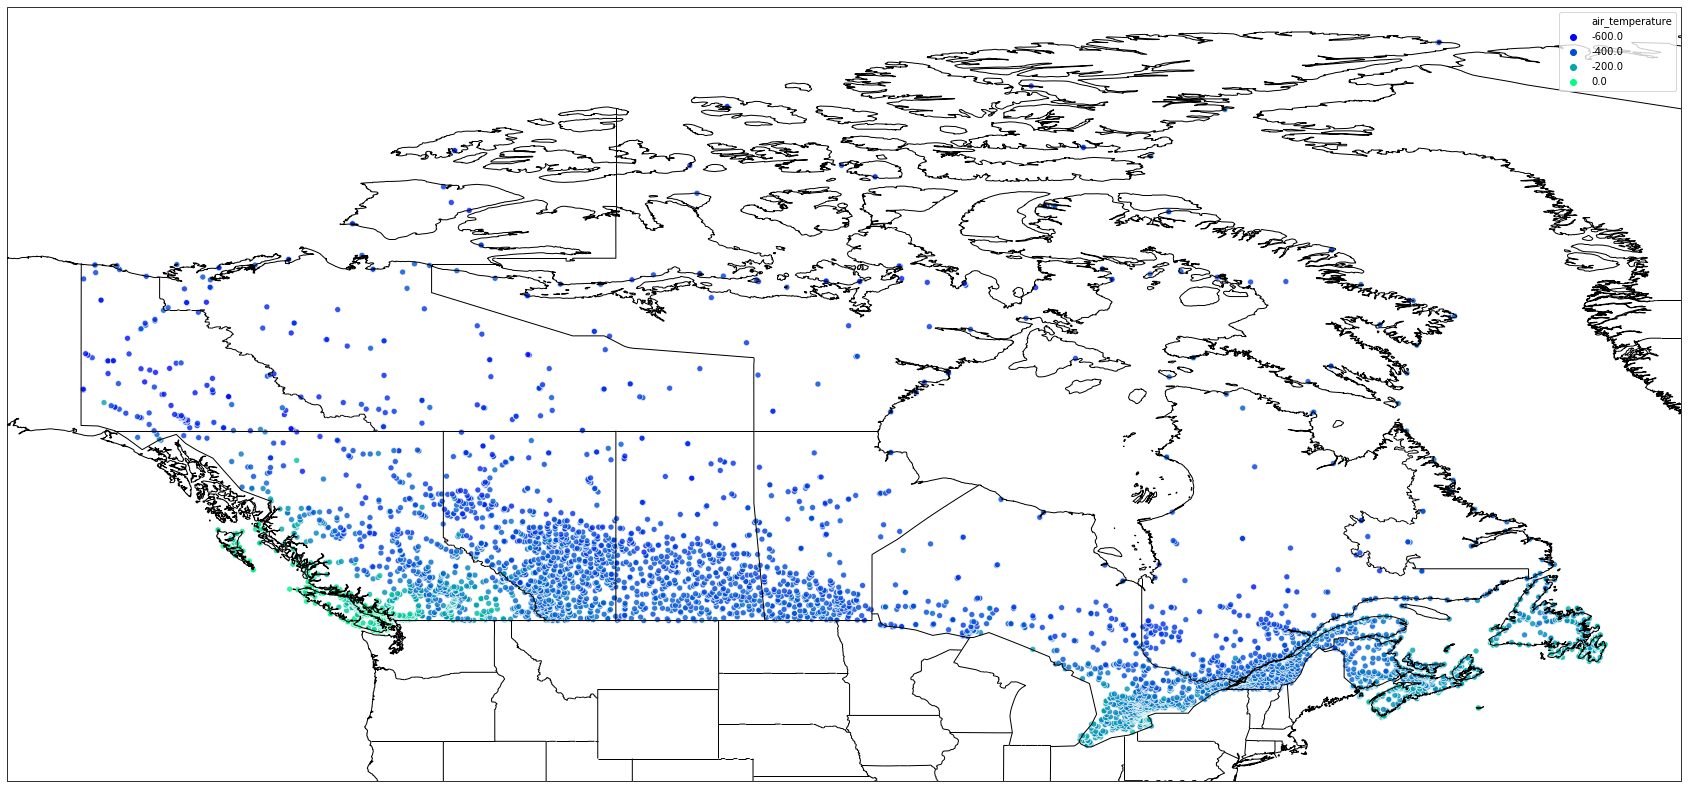

In [45]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(df_complete['lon'], df_complete['lat'], hue=df_complete['air_temperature'], palette="winter", alpha=.8)
#plt.ylim(40, 80)
#plt.xlim(-126, -119)
plt.savefig('./plots/jan1/1st_percentile_spatial.pdf')

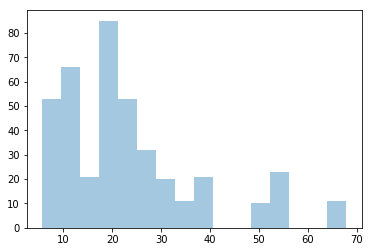

In [113]:
sns.distplot(df_rain_new['rainfall_rate_new'].dropna().values, kde=False)

In [114]:
#df_rain_rate['obs_count'].value_counts().idxmax()

In [115]:
sns.distplot(df_dv[df_dv['dv'] < 60]['dv'])#.hist(bins = 100)
plt.xlabel('15 Min Rain 10 yr return period')
plt.savefig('./plots/15_min_rain.pdf')

NameError: name 'df_dv' is not defined

In [122]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing

X = df_rain_one[['rainfall_rate', 'lat', 'lon']]
scaler = preprocessing.StandardScaler().fit_transform(X)
labels = KMeans(n_clusters = 10, random_state=0).fit(X).labels_
X['labels'] = labels
X

/home/nannau/Desktop/map-xtreme/venv2/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,rainfall_rate,lat,lon,labels
0,5.4,45.6084,-61.6797,7
1,8.2,46.4600,-61.9883,7
2,235.6,48.3694,-89.3272,1
3,1.5,49.3998,-98.3192,8
4,503.6,50.4333,-104.6670,6
5,306.8,50.6306,-93.2214,9
6,306.5,55.5333,-102.3500,9
7,428.9,64.3167,-96.0000,6
8,0.0,70.4833,-68.5167,7
9,241.7,72.6933,-77.9575,1


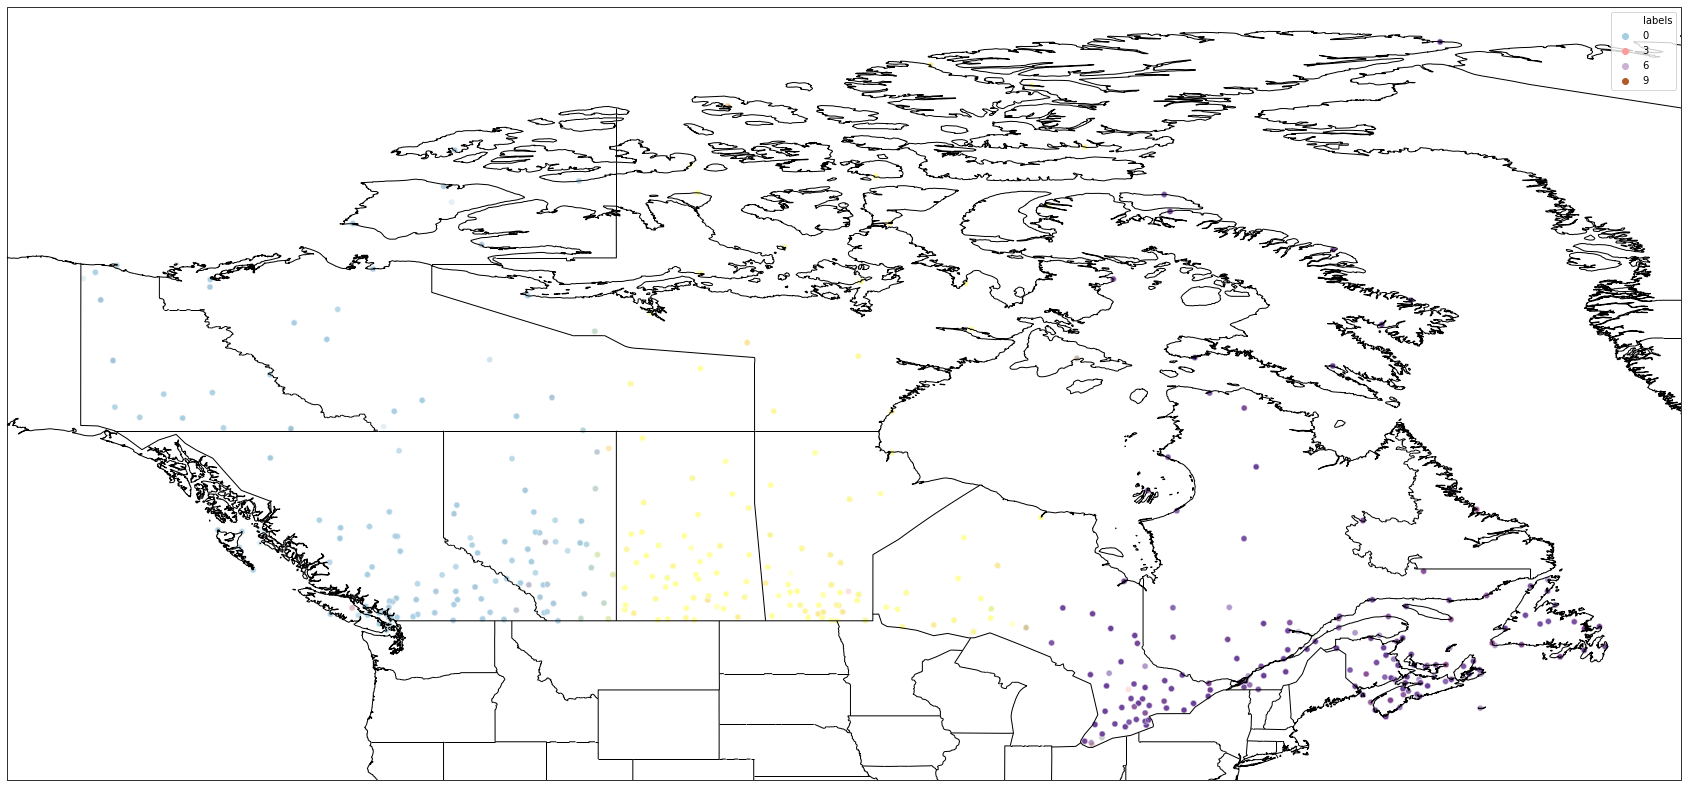

In [121]:
fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(X['lon'], X['lat'], hue=X['labels'], palette="Paired", alpha=.3)
#plt.ylim(40, 80)
#plt.xlim(-126, -119)
plt.savefig('./plots/canada_15_min_rain_labelled.pdf')

ValueError: 'c' argument has 3367 elements, which is not acceptable for use with 'x' with size 3169, 'y' with size 3169.

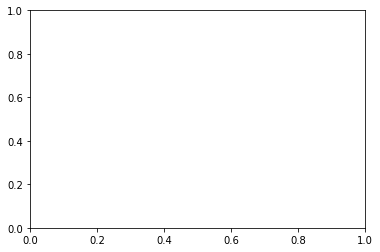

In [90]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df_rain_new['elev'], s=0.5)

In [ ]:
import sklearn.model_selection
import sklearn.datasets

import autosklearn.regression

X = df_rain_rate[['lat', 'lon', 'completeness']].values
y = df_rain_rate[['rainfall_rate']].values

def main():
    X, y = sklearn.datasets.load_boston(return_X_y=True)
    feature_types = (['numerical'] * 3) + ['categorical'] + (['numerical'] * 9)
    X_train, X_test, y_train, y_test = \
        sklearn.model_selection.train_test_split(X, y, random_state=1)

    automl = autosklearn.regression.AutoSklearnRegressor(
        time_left_for_this_task=120,
        per_run_time_limit=30,
        tmp_folder='./tmp/autosklearn_regression_example_tmp',
        output_folder='./tmp/autosklearn_regression_example_out',
    )
    automl.fit(X_train, y_train, dataset_name='boston',
               feat_type=feature_types)

    print(automl.show_models())
    predictions = automl.predict(X_test)

if __name__ == '__main__':
    main()

In [35]:
np.euler_gamma

0.5772156649015329

In [37]:

df_fit = df_one_day

,rainfall_rate,time_min,time_max,lat,lon,station_id,completeness,freq
0,5.4,2004-05-28 15:00:00,2004-12-31 23:00:00,45.6084,-61.6797,8313,0.595021,
1,8.2,2004-05-27 20:00:00,2004-12-31 23:00:00,46.4600,-61.9883,8368,0.597160,
2,235.6,2004-09-03 22:00:00,2004-12-31 23:00:00,48.3694,-89.3272,5302,0.325573,
3,1.5,2004-11-14 07:00:00,2004-12-31 23:00:00,49.3998,-98.3192,4674,0.130075,
4,503.6,2004-06-16 22:00:00,2004-12-31 23:00:00,50.4333,-104.6670,3990,0.498170,
5,306.8,2004-07-27 16:00:00,2004-12-31 23:00:00,50.6306,-93.2214,5112,0.425875,
6,306.5,2004-09-13 13:00:00,2004-12-31 23:00:00,55.5333,-102.3500,4417,0.294915,
7,428.9,2004-06-30 17:00:00,2004-12-31 23:00:00,64.3167,-96.0000,2092,0.473844,
8,0.0,2004-12-20 16:00:00,2004-12-31 23:00:00,70.4833,-68.5167,2208,0.023272,
9,241.7,2004-09-18 15:00:00,2004-09-21 16:00:00,72.6933,-77.9575,2283,0.008271,
